In [143]:
import time
import logging
import random
from datetime import datetime, timezone, timedelta
logging.basicConfig(level=logging.INFO)

import pytz
import requests
import execjs # pip install PyExecJs
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
from tqdm.notebook import tqdm

buy_window = 80
sell_window = 300
cache = dict()

INFO:root:download from http://fund.eastmoney.com/pingzhongdata/110020.js?v=20210726121904


,x,y,baseline,buy,cost,position,value,return
2890,2021-07-19 00:00:00+08:00,1.8450,1.601284,0.0,92.0,18.405441,171.405441,1.863103
2891,2021-07-20 00:00:00+08:00,1.8437,1.600156,0.0,92.0,18.392472,171.392472,1.862962
2892,2021-07-21 00:00:00+08:00,1.8562,1.611005,0.0,92.0,18.517170,171.517170,1.864317
2893,2021-07-22 00:00:00+08:00,1.8600,1.614303,0.0,92.0,18.555078,171.555078,1.864729
2894,2021-07-23 00:00:00+08:00,1.8389,1.595990,0.0,92.0,18.344588,171.344588,1.862441


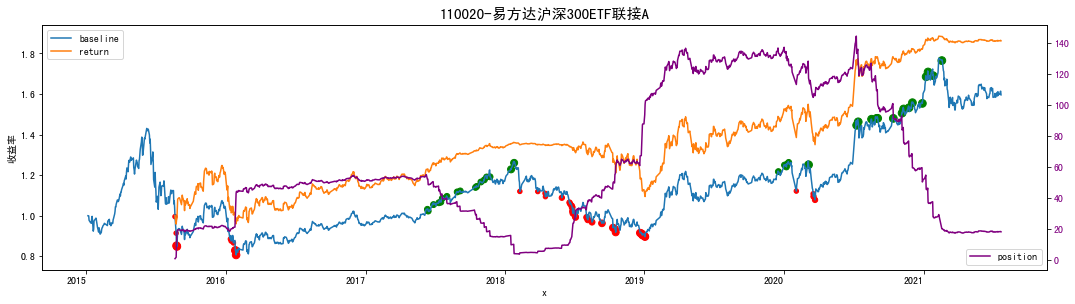

In [144]:
from fund import Fund

class MyFund(Fund):

    @classmethod
    def download(cls, code):
        """get data from 天天基金"""
        if code in cache:
            logging.info('load from cache which might be stale')
            name, df = cache.get(code)
        else:
            url = 'http://fund.eastmoney.com/pingzhongdata/{0}.js?v={1}'.format(code, time.strftime("%Y%m%d%H%M%S",time.localtime()))
            logging.info('download from %s' % url)
            r = requests.get(url)
            assert r.status_code == 200
            jsContent = execjs.compile(r.text)
            name = jsContent.eval('fS_name')
            ACWorthTrend = jsContent.eval('Data_ACWorthTrend')
            df = pd.DataFrame(ACWorthTrend, columns=['x', 'y'])
            df.x = pd.to_datetime(df['x'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Shanghai')
            cache[code] = (name, df)
        return name, df

    def backtest(self, start_date=None, end_date=None):
        if not self.name:
            self.name, self.df = MyFund.download(self.code)
        if start_date is None:
            start_date = self.df.iloc[0]['x']
        if end_date is None:
            end_date = self.df.iloc[-1]['x']
        # to suppress the warning: A value is trying to be set on a copy of a slice from a DataFrame.
        df = self.df.copy(deep=True)
        df = df.loc[(df.x >= start_date) & (df.x <= end_date)]
        df['baseline'] = df['y'] / df.iloc[0]['y'] # buy and hold
        df['buy'] = 0.          # 买入或卖出的金额
        df['cost'] = np.nan     # 成本
        df['position'] = np.nan # 持仓
        df['value'] = np.nan    # 总资产 = 持仓 + 已经赎回的现金
        df['return'] = np.nan   # 累计收益率 = 总资产 / 成本的极大值
        cost = 0  # 成本
        share = 0 # 份额
        money = 0 # 已经赎回的部分
        worth = df.y.tolist()
        for i, j in enumerate(df.index):
            x = self.buy_or_sell(worth[:i+1])
            df.at[j, 'buy'] = x
            y = worth[i]
            if x < 0:
                # sell
                x = -min(-x, share * y)
                money -= x
            else:
                # buy
                if x < money:
                    money -= x
                else:
                    cost += (x - money)
                    money = 0
            assert share >= -1e-6, share
            share += x/y
            position = share * y
            value = position + money
            if cost > 0:
                r = value / cost
                df.at[j, 'return'] = r
                df.at[j, 'cost'] = cost
                df.at[j, 'value'] = value
                df.at[j, 'position'] = position
        return df

    def display(self, df):
        fig, ax1 = plt.subplots(figsize=(18,5))
        df.plot(x='x', y=['baseline', 'return'], ax=ax1)
        buy = df[df['buy'] > 0]
        sell = df[df['buy'] < 0]
        # 点越大，表示金额越大
        buy.plot(x='x', y=['baseline'], ax=ax1, kind='scatter', color='red', s=20*np.sqrt(buy['buy']))
        sell.plot(x='x', y=['baseline'], ax=ax1, kind='scatter', color='green', s=20*np.sqrt(np.absolute(sell['buy'])))
        ax1.set_ylabel('收益率')
        ax1.set_title('{0}-{1}'.format(self.code, self.name), fontsize=15)
        ax2 = ax1.twinx()
        color = 'purple'
        df.plot(x='x', y=['position'], ax=ax2, color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='lower right')
        return df

class MyFund1(MyFund):
    def buy_or_sell(self, worth):
        '''buy_window和sell_window是两个重要的参数，但不要过分依赖调参，否则会过拟合'''
        l = len(worth)
        assert l > 0
        current = worth[-1]
        if l >= buy_window:
            for k in range(8, 0, -1):
                if current == min(worth[-k * buy_window:]):
                    return k
        if l >= sell_window:
            for k in range(3, 0, -1):
                if worth[-2] == max(worth[-k * sell_window:]):
                    return -k * 3
        return 0


f = MyFund1('110020')
start = pytz.timezone('Asia/Shanghai').localize(datetime(2015, 1, 1))
df100 = f.backtest(start)
f.display(df100)
df100.iloc[-5:]

In [145]:
for k,v in cache.items():
    print(k, v[0])

110020 易方达沪深300ETF联接A



## 使用Pandas提供的方法也可以做类似的模拟

INFO:root:download from http://fund.eastmoney.com/pingzhongdata/005918.js?v=20210726121906


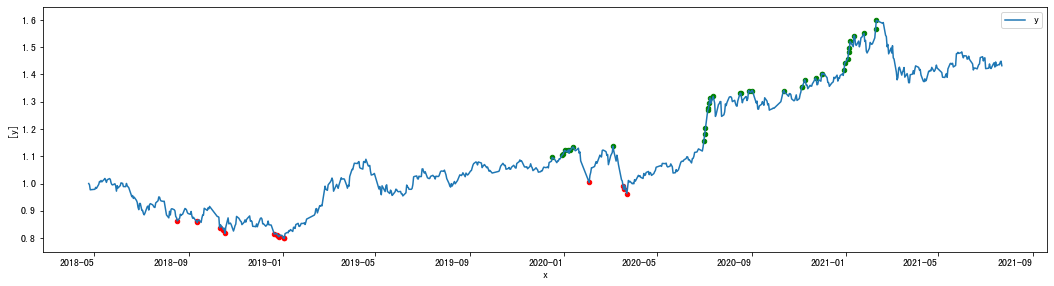

In [146]:
_, df = MyFund.download('005918')
df['y_rolling_min'] = df['y'].rolling(buy_window).min()
df['y_rolling_max'] = df['y'].rolling(sell_window).max()


start = pytz.timezone('Asia/Shanghai').localize(datetime(2015, 1, 1))
df2 = df.loc[df.x >= start]
buy = df2.loc[df2['y'] == df2['y_rolling_min']]
sell = df2.loc[df2['y'] == df2['y_rolling_max']]

fig, ax = plt.subplots(figsize=(18,5))
df2.plot(x='x', y=['y'], ax=ax)
buy.plot(x='x', y=['y'], ax=ax, kind='scatter', color='red')
sell.plot(x='x', y=['y'], ax=ax, kind='scatter', color='green')
# ax.set_title(name)


## Benchmark
随机选择一个起始日期，分别计算接下来的两年里以下三种策略的收益：

1. 定投，也就是MyFund
2. 市场，也就是一年之后的实际涨幅，等同于买入持有 (Buy and Hold)策略
3. 模型1，也就是MyFund1

以上操作重复100次，从而得出模型1相对其他两种策略的胜率

In [147]:
code = '110020'
random.seed(10)
baseline = MyFund(code)
model = MyFund1(code)
name, df = MyFund.download(f.code)

repeat = 100 # this is mutable
occurence = set()
gain = []
up_limit = len(df)

with tqdm(total=repeat) as pbar:
    while len(gain) < repeat:
        i = random.randrange(0, up_limit)
        if (i in occurence):
            continue
        else:
            occurence.add(i)
        start_date = df.iloc[i]['x']
        end_date = start_date + timedelta(days=365*2)
        if (df.iloc[-1]['x'] < end_date):
            up_limit = i
            if up_limit < repeat:
                repeat = up_limit
        else:
            r = baseline.backtest(start_date, end_date)
            r1 = model.backtest(start_date, end_date)
            gain.append((r.iloc[-1]['baseline'], r.iloc[-1]['return'], r1.iloc[-1]['return']))
            pbar.update(1)
            # pbar.write('iteration {0} done'.format(len(gain)))

df_b = pd.DataFrame(gain, columns=['市场', '定投', 'model1'])
print('平均收益率：')
for c in list(df_b.columns):
    print('{}:\t{:.3f}'.format(c, df_b[c].mean()))
print('\n')
df_b.fillna(1)
print('跟市场相比的胜率：{:.2f}'.format(len(df_b[df_b['model1'] >= df_b['市场']])/repeat))
print('跟定投相比的胜率：{:.2f}'.format(len(df_b[df_b['model1'] >= df_b['定投']])/repeat))

INFO:root:load from cache which might be stale


INFO:root:load from cache which might be stale
INFO:root:load from cache which might be stale



平均收益率：
市场:	1.125
定投:	1.064
model1:	1.164


跟市场相比的胜率：0.67
跟定投相比的胜率：0.87
